In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [7]:
import math
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# ======================= KANLinear =======================

class KANLinear(torch.nn.Module):
    def __init__(self, in_features, out_features, grid_size=5, spline_order=3,
                 scale_noise=0.1, scale_base=1.0, scale_spline=1.0,
                 enable_standalone_scale_spline=True, base_activation=torch.nn.SiLU,
                 grid_eps=0.02, grid_range=(-1.0, 1.0), eps=1e-8):
        super().__init__()
        self.in_features, self.out_features = in_features, out_features
        self.grid_size, self.spline_order = grid_size, spline_order
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.scale_noise, self.scale_base, self.scale_spline = scale_noise, scale_base, scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps
        self.eps = eps

        # Knots (open uniform with order padding)
        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (torch.arange(-spline_order, grid_size + spline_order + 1) * h + grid_range[0]) \
               .expand(in_features, -1).contiguous()
        self.register_buffer("grid", grid)

        # Parameters
        self.base_weight   = torch.nn.Parameter(torch.empty(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(torch.empty(out_features, in_features, grid_size + spline_order))
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(torch.ones(out_features, in_features))  # start at 1.0

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = ((torch.rand(self.grid_size + 1, self.in_features, self.out_features) - 0.5)
                     * self.scale_noise / max(1, self.grid_size))
            coeff = self.curve2coeff(self.grid.T[self.spline_order:-self.spline_order], noise)
            if self.enable_standalone_scale_spline:
                self.spline_weight.copy_(coeff)      # scaler handles the amplitude
            else:
                self.spline_weight.copy_(self.scale_spline * coeff)

    def b_splines(self, x: torch.Tensor):
        """Return B-spline basis: (B, in, grid_size + spline_order)."""
        assert x.dim() == 2 and x.size(1) == self.in_features
        B = x.size(0)
        x = x.to(self.grid.dtype).unsqueeze(-1)  # (B, in, 1)
        grid = self.grid  # (in, K+2p+1)

        # Initial piecewise-constant basis (order 0)
        left = x >= grid[:, :-1]
        right = x < grid[:, 1:]
        right_last = x <= grid[:, 1:]
        bases = (left & right).to(x.dtype)
        bases[:, :, -1] = (left[:, :, -1] & right_last[:, :, -1]).to(x.dtype)

        # Cox–de Boor recursion with safe denominators
        for k in range(1, self.spline_order + 1):
            denom_left  = (grid[:, k:-1]  - grid[:, :-(k+1)]).clamp_min(self.eps)
            denom_right = (grid[:, k+1:]  - grid[:, 1:(-k)]).clamp_min(self.eps)
            term_left  = ((x - grid[:, :-(k+1)]) / denom_left)  * bases[:, :, :-1]
            term_right = ((grid[:, k+1:] - x) / denom_right)    * bases[:, :,  1:]
            bases = term_left + term_right

        Keff = self.grid_size + self.spline_order
        assert bases.size() == (B, self.in_features, Keff)
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        """
        x: (K+1, in), y: (K+1, in, out). Returns (out, in, K+order)
        """
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size(0) == x.size(0) and y.size(1) == self.in_features
        A = self.b_splines(x).transpose(0, 1)  # (in, B, Keff)
        B = y.transpose(0, 1)                  # (in, B, out)
        sol = torch.linalg.lstsq(A, B, driver=None).solution  # (in, Keff, out)
        return sol.permute(2, 0, 1).contiguous()              # (out, in, Keff)

    @property
    def scaled_spline_weight(self):
        W = self.spline_weight
        if self.enable_standalone_scale_spline:
            W = W * self.spline_scaler.unsqueeze(-1)
        return W.contiguous()

    def forward(self, x: torch.Tensor):
        assert x.size(-1) == self.in_features
        flat = x.reshape(-1, self.in_features)
        base   = torch.nn.functional.linear(self.base_activation(flat), self.base_weight)
        Bspl   = self.b_splines(flat)
        spline = torch.nn.functional.linear(
            Bspl.view(flat.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1)
        )
        out = base + spline
        return out.view(*x.shape[:-1], self.out_features)


# ======================= KAN wrapper =======================

class KAN(torch.nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=2,
        spline_order=1,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=(-1, 1),
    ):
        super(KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = torch.nn.ModuleList()
        for in_features, out_features in zip(layers_hidden[:-1], layers_hidden[1:]):
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x: torch.Tensor, update_grid=False):
        # NOTE: we don't have layer.update_grid defined, so keep update_grid=False.
        for layer in self.layers:
            x = layer(x)
        return x

    # If you don't define layer.regularization_loss in KANLinear,
    # it's safer to drop this or implement it there.
    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        return 0.0

    @torch.no_grad()
    def first_layer_contrib_importance(self, x, combine='sum', absmean=True, normalize=True):
        """
        Returns per-feature importance from the first KANLinear by measuring
        average magnitude of each feature's contribution (base + spline) on data X.
        """
        l0 = self.layers[0]
        x = torch.as_tensor(x, dtype=torch.float32)
        flat = x.reshape(-1, l0.in_features)

        # Base contribution per feature j → (N, in, out)
        a = l0.base_activation(flat)         # (N, in)
        base_contrib_j = torch.einsum('ni,oi->nio', a, l0.base_weight)  # (N, in, out)

        # Spline contribution per feature j → (N, in, out)
        Bspl = l0.b_splines(flat)            # (N, in, K)
        Ws   = l0.scaled_spline_weight       # (out, in, K)
        spline_contrib_j = torch.einsum('nik,oik->nio', Bspl, Ws)       # (N, in, out)

        # Per-feature magnitude on data
        contrib = base_contrib_j + spline_contrib_j                     # (N, in, out)
        if absmean:
            per_feat = contrib.abs().mean(dim=(0, 2))                   # (in,)
        else:
            per_feat = (contrib.pow(2).mean(dim=(0, 2))).sqrt()

        if normalize:
            s = per_feat.sum().clamp(min=1e-12)
            per_feat = per_feat / s
        return per_feat.cpu()

    @torch.no_grad()
    def get_feature_importance(self, method, x=None, y=None,
                               task="classification", loss_fn=None,
                               reduction="sum_logits"):
        m = method.lower()
        if m == "kan_l1":
            return self.first_layer_contrib_importance(x, absmean=True)
        if m == "kan_l2":
            return self.first_layer_contrib_importance(x, absmean=False)
        if m == "kan_ko":
            if x is None or y is None or loss_fn is None:
                raise ValueError("KAN-KO needs x, y, loss_fn")
            return self.knockout_delta_loss_full(
                x, y, loss_fn, task=task, normalize=True, clip_negative=True
            )

        if m == "kan_si":
            if x is None:
                raise ValueError("KAN-SI needs x")
            torch.set_grad_enabled(True)
            try:
                x_req = x.detach().requires_grad_(True)
                out = self.forward(x_req)
                if task == "classification":
                    if out.dim() == 2 and out.size(1) > 1:
                        obj = out.abs().sum() if reduction == "sum_logits" else out.abs().mean()
                    else:
                        obj = out.squeeze(-1).abs().sum()
                else:
                    obj = out.squeeze(-1).abs().sum()
                self.zero_grad(set_to_none=True)
                if x_req.grad is not None:
                    x_req.grad.zero_()
                obj.backward()
                grads = x_req.grad.detach().abs().mean(dim=0)
                imps = grads / (grads.sum() + 1e-12)
                return imps.cpu()
            finally:
                torch.set_grad_enabled(False)

        raise ValueError("method must be one of {'kan_l1','kan_l2','kan_si','kan_ko'}")

    @torch.no_grad()
    def knockout_delta_loss_full(self, x, y, loss_fn, *, task="regression",
                                 normalize=True, clip_negative=True):
        """
        Feature knockout measured at the FINAL head (full forward).
        """
        base_out = self.forward(x)

        if task == "classification":
            assert base_out.ndim == 2 and y.ndim == 1, \
                f"[KO base] clf shapes: out {base_out.shape}, y {y.shape}"
        else:
            if y.shape != base_out.shape:
                try:
                    y = y.view_as(base_out)
                except RuntimeError as e:
                    raise RuntimeError(
                        f"[KO base] reg shapes mismatch: out {base_out.shape}, y {y.shape}"
                    ) from e

        base_loss = float(loss_fn(base_out, y).item())

        l0 = self.layers[0]
        d_in = l0.in_features
        deltas = x.new_zeros(d_in)

        for j in range(d_in):
            saved_base   = l0.base_weight[:, j].clone()
            saved_spline = l0.spline_weight[:, j, :].clone()
            saved_scaler = (
                l0.spline_scaler[:, j].clone()
                if getattr(l0, "enable_standalone_scale_spline", False)
                else None
            )

            l0.base_weight[:, j].zero_()
            l0.spline_weight[:, j, :].zero_()
            if saved_scaler is not None:
                l0.spline_scaler[:, j].zero_()

            out_j = self.forward(x)

            if task == "classification":
                assert out_j.ndim == 2 and out_j.shape[1] == base_out.shape[1], \
                    f"[KO step] clf out shape {out_j.shape} != (N,{base_out.shape[1]})"
            else:
                if out_j.shape != base_out.shape or out_j.shape != y.shape:
                    raise RuntimeError(
                        f"[KO step] reg shapes: out {out_j.shape}, base {base_out.shape}, y {y.shape}"
                    )

            L = float(loss_fn(out_j, y).item())
            delta = L - base_loss
            if clip_negative:
                delta = max(0.0, delta)
            deltas[j] = delta

            # Restore
            l0.base_weight[:, j].copy_(saved_base)
            l0.spline_weight[:, j, :].copy_(saved_spline)
            if saved_scaler is not None:
                l0.spline_scaler[:, j].copy_(saved_scaler)

        if normalize:
            s = deltas.sum()
            if s > 0:
                deltas = deltas / (s + 1e-12)
        return deltas.detach().cpu()


# ======================= Targets & training =======================

def prepare_target(y, task):
    y_arr = np.asarray(y)

    if task == "classification":
        if pd.isna(y_arr).any():
            raise ValueError("y contains NaNs; impute or drop them before training.")

        if pd.api.types.is_numeric_dtype(y_arr) and y_arr.dtype != object:
            classes_sorted = np.sort(np.unique(y_arr))
            remap = {v: i for i, v in enumerate(classes_sorted)}
            y_enc = np.vectorize(remap.get)(y_arr)
            encoder = ("mapping", remap, classes_sorted)
        else:
            le = LabelEncoder()
            y_enc = le.fit_transform(y_arr.astype(str))
            encoder = ("labelencoder", le, le.classes_)
        return task, y_enc.astype(np.int64), encoder
    else:
        return task, y_arr.astype(np.float32), None


def _train_kan(X_tr, y_tr, task, seed=0):
    X_tr = np.asarray(X_tr)
    y_tr = np.asarray(y_tr)

    torch.manual_seed(seed)
    np.random.seed(seed)

    n_in = X_tr.shape[1]
    if task == "classification":
        n_classes = int(np.unique(y_tr).shape[0])
        layers = [n_in, n_in * 2 + 1, n_classes]
        ytr_t = torch.as_tensor(y_tr, dtype=torch.long)
        loss_fn = torch.nn.CrossEntropyLoss()
    else:
        layers = [n_in, n_in * 2 + 1, 1]
        ytr_t = torch.as_tensor(y_tr.reshape(-1, 1), dtype=torch.float32)
        loss_fn = torch.nn.MSELoss()

    model = KAN(layers_hidden=layers)
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)

    ds = torch.utils.data.TensorDataset(
        torch.as_tensor(X_tr, dtype=torch.float32),
        ytr_t
    )
    loader = torch.utils.data.DataLoader(ds, batch_size=64, shuffle=True)

    model.train()
    for _ in range(200):
        for xb, yb in loader:
            opt.zero_grad()
            out = model(xb)
            loss = loss_fn(out, yb)
            loss.backward()
            opt.step()

    model.eval()
    return model, loss_fn


# ======================= 1D response & plotting =======================

@torch.no_grad()
def one_d_response_first_layer(model, feature_idx, out_idx=0, n_points=200):
    """
    Return x-grid and 1D response f_j(x_j) for feature j at output out_idx,
    using only the first KANLinear layer (base + spline).
    """
    l0 = model.layers[0]
    in_features = l0.in_features
    Keff = l0.grid_size + l0.spline_order

    # Use actual interior knot range for this feature
    grid = l0.grid[feature_idx]  # (K+2p+1,)
    x_min = grid[l0.spline_order].item()
    x_max = grid[-l0.spline_order-1].item()

    xs = torch.linspace(x_min, x_max, n_points)
    X = torch.zeros(n_points, in_features)
    X[:, feature_idx] = xs

    a = l0.base_activation(X)                     # (N, in)
    a_j = a[:, feature_idx]                       # (N,)
    w_base_j = l0.base_weight[out_idx, feature_idx]
    f_base = a_j * w_base_j                       # (N,)

    Bspl = l0.b_splines(X)                        # (N, in, Keff)
    B_j = Bspl[:, feature_idx, :]                 # (N, Keff)
    w_spline_j = l0.scaled_spline_weight[out_idx, feature_idx, :]
    f_spline = B_j @ w_spline_j                   # (N,)

    f_total = f_base + f_spline
    return xs.cpu().numpy(), f_total.cpu().numpy(), f_base.cpu().numpy(), f_spline.cpu().numpy()


def plot_feature_response(
    model,
    feature_idx,
    feature_name,
    dataset_name,
    out_idx=0,
    show_base_spline=True,
    save_path=None,
    method_name=None,   # e.g. "KAN-L2" / "KAN-SI" (for filename & title)
):
    """
    Plot 1D KAN response for a single feature and optionally save the figure.

    - show_base_spline: if True, also show base and spline parts separately.
    - save_path: if not None, save figure to this path.
    - method_name: optional string for title/filename context (e.g., "KAN-L2").
    """
    xs, f_total, f_base, f_spline = one_d_response_first_layer(
        model, feature_idx, out_idx=out_idx
    )

    # ----------------- Figure setup -----------------
    plt.figure(figsize=(5, 3.5), dpi=150)

    # Main curve: base + spline
    plt.plot(xs, f_total, linewidth=2.2, label="Total (base + spline)")

    if show_base_spline:
        plt.plot(xs, f_base, linestyle="--", linewidth=1.5, label="Base part")
        plt.plot(xs, f_spline, linestyle=":", linewidth=1.5, label="Spline part")

    # Horizontal zero line for reference
    plt.axhline(0.0, color="gray", linestyle="--", linewidth=0.8)

    # ----------------- Labels & title -----------------
    x_label = f"{feature_name} (normalized)"
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel("First-layer contribution", fontsize=12)

    if method_name is not None:
        title = f"{dataset_name}: {method_name} response for {feature_name}"
    else:
        title = f"{dataset_name}: KAN response for {feature_name}"
    plt.title(title, fontsize=13, pad=8)

    # ----------------- Style tweaks -----------------
    plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.4)
    plt.tick_params(axis="both", which="major", labelsize=10)
    plt.legend(fontsize=9, frameon=True, loc="best")

    plt.tight_layout()

    # ----------------- Save (optional) -----------------
    if save_path is None:
        # Build a clean default filename
        safe_ds = str(dataset_name).replace(" ", "_")
        safe_feat = str(feature_name).replace(" ", "_").replace("/", "_")
        safe_method = (method_name or "KAN").replace(" ", "_")
        save_path = f"{safe_ds}_{safe_method}_{safe_feat}.png"

    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

    return save_path



Breast Cancer – Top-3 features (KAN-L2):
  worst concave points  (importance=0.061)
  radius error  (importance=0.060)
  mean concave points  (importance=0.055)


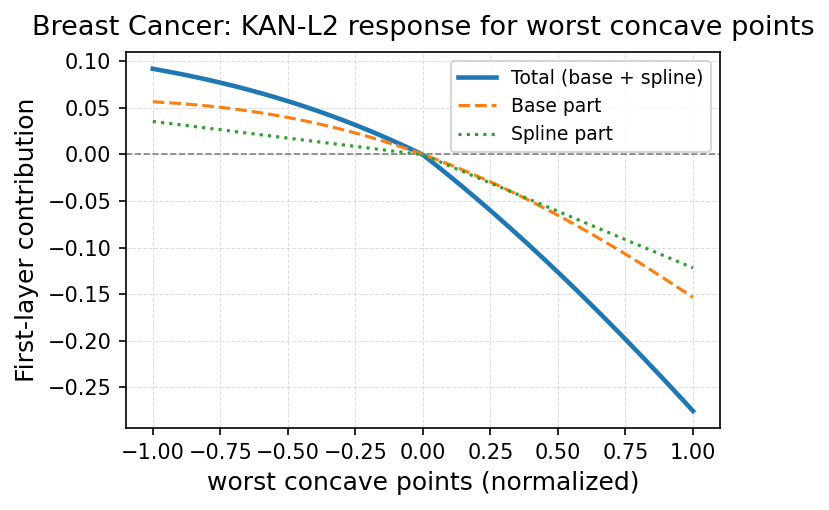

Saved: Breast_Cancer_KAN-L2_worst_concave_points.png


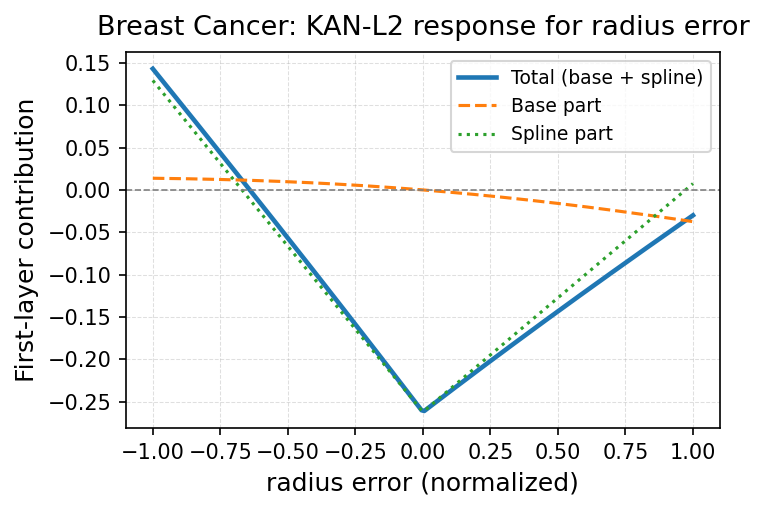

Saved: Breast_Cancer_KAN-L2_radius_error.png


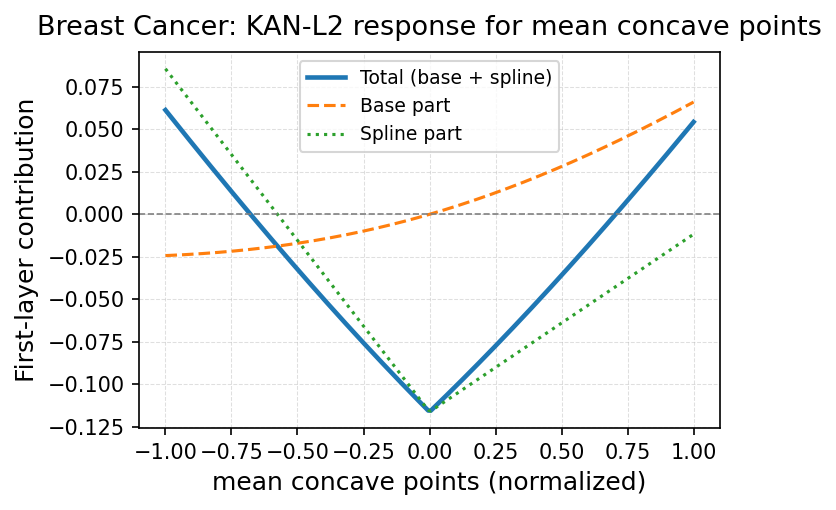

Saved: Breast_Cancer_KAN-L2_mean_concave_points.png


In [8]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# ---------- Load + scale ----------
bc = load_breast_cancer()
X_bc = bc.data
y_bc = bc.target
feature_names_bc = np.array(bc.feature_names)

# Scale to [-1, 1] to match KAN grid_range
scaler_bc = MinMaxScaler(feature_range=(-1, 1))
X_bc_scaled = scaler_bc.fit_transform(X_bc)

# ---------- Prepare target + split ----------
task_bc, y_bc_enc, _ = prepare_target(y_bc, task="classification")

Xtr_bc, Xte_bc, ytr_bc, yte_bc = train_test_split(
    X_bc_scaled, y_bc_enc, test_size=0.2, random_state=0, stratify=y_bc_enc
)

# ---------- Train KAN ----------
model_bc, loss_bc = _train_kan(Xtr_bc, ytr_bc, task="classification", seed=0)

# ---------- Feature importance (KAN-L2 or KAN-SI) ----------
Xtr_bc_t = torch.as_tensor(Xtr_bc, dtype=torch.float32)

# KAN-L2
imp_l2_bc = model_bc.get_feature_importance("kan_l2", x=Xtr_bc_t, task="classification")
imp_l2_bc = np.asarray(imp_l2_bc)
top_idx_l2_bc = np.argsort(imp_l2_bc)[::-1][:3]   # top-3

print("Breast Cancer – Top-3 features (KAN-L2):")
for j in top_idx_l2_bc:
    print(f"  {feature_names_bc[j]}  (importance={imp_l2_bc[j]:.3f})")

# ---------- Plot 1D responses for those features ----------
# For binary clf, output index 1 usually = malignant class logit
# for j in top_idx_l2_bc:
#     plot_feature_response(
#         model_bc,
#         feature_idx=j,
#         feature_name=feature_names_bc[j],
#         dataset_name="Breast Cancer",
#         out_idx=1,     # positive/malignant class
#     )
for j in top_idx_l2_bc[:3]:
    fname = plot_feature_response(
        model_bc,
        feature_idx=j,
        feature_name=feature_names_bc[j],
        dataset_name="Breast Cancer",
        out_idx=1,               # positive/malignant class
        show_base_spline=True,
        save_path=None,          # let it auto-generate a filename
        method_name="KAN-L2",
    )
    print("Saved:", fname)


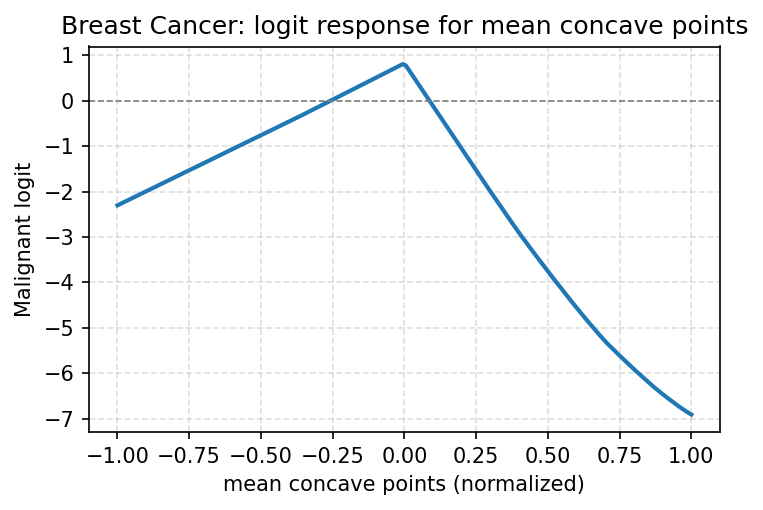

In [9]:
# imp_si_bc = model_bc.get_feature_importance("kan_si", x=Xtr_bc_t, task="classification")
# imp_si_bc = np.asarray(imp_si_bc)
# top_idx_si_bc = np.argsort(imp_si_bc)[::-1][:3]

# print("\nBreast Cancer – Top-3 features (KAN-SI):")
# for j in top_idx_si_bc:
#     print(f"  {feature_names_bc[j]}  (importance={imp_si_bc[j]:.3f})")

# # for j in top_idx_si_bc:
# #     plot_feature_response(
# #         model_bc,
# #         feature_idx=j,
# #         feature_name=feature_names_bc[j],
# #         dataset_name="Breast Cancer",
# #         out_idx=1,
# #     )
# for j in top_idx_si_bc:
#     fname = plot_feature_response(
#         model_diam,
#         feature_idx=j,
#         feature_name=feature_names_bc[j],
#         dataset_name="Breast Cancer",
#         out_idx=0,              # single regression output
#         show_base_spline=True,
#         save_path=None,
#         method_name="KANSI",
#     )
#     print("Saved:", fname)

@torch.no_grad()
def one_d_response_final_logit(model, feature_idx, class_idx, x_ref, n_points=200):
    """
    x_ref: reference input (e.g. mean of X_train), shape (d,)
    class_idx: index of the class logit (e.g. 0 = malignant, 1 = benign)
    """
    x_ref = np.asarray(x_ref, dtype=np.float32)
    d = x_ref.shape[0]

    # use the first layer's grid to pick plotting range for this feature
    l0 = model.layers[0]
    grid = l0.grid[feature_idx]
    x_min = grid[l0.spline_order].item()
    x_max = grid[-l0.spline_order-1].item()

    xs = torch.linspace(x_min, x_max, n_points)
    X = torch.from_numpy(np.tile(x_ref, (n_points, 1))).float()
    X[:, feature_idx] = xs

    logits = model(X)                  # (N, C)
    f = logits[:, class_idx]           # (N,)

    return xs.numpy(), f.numpy()


# choose a reference point, e.g. mean of X_train (already scaled)
x_ref_bc = Xtr_bc.mean(axis=0)

# say feature j is "worst concave points"
xs, logit_malignant = one_d_response_final_logit(
    model_bc,
    feature_idx=1,
    class_idx=0,        # malignant class
    x_ref=x_ref_bc,
)

plt.figure(figsize=(5,3.5), dpi=150)
plt.plot(xs, logit_malignant, lw=2)
plt.axhline(0, color="gray", ls="--", lw=0.8)
plt.xlabel(f"{feature_names_bc[j]} (normalized)")
plt.ylabel("Malignant logit")
plt.title("Breast Cancer: logit response for mean concave points")
plt.grid(True, ls="--", alpha=0.4)
plt.tight_layout()
plt.show()


In [ ]:
# from sklearn.datasets import load_breast_cancer
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MinMaxScaler

# # ---------- Load + scale ----------
# bc = load_breast_cancer()
# X_bc = bc.data
# y_bc = bc.target
# feature_names_bc = np.array(bc.feature_names)

# # Scale to [-1, 1] to match KAN grid_range
# scaler_bc = MinMaxScaler(feature_range=(-1, 1))
# X_bc_scaled = scaler_bc.fit_transform(X_bc)

# # ---------- Prepare target + split ----------
# task_bc, y_bc_enc, _ = prepare_target(y_bc, task="classification")

# Xtr_bc, Xte_bc, ytr_bc, yte_bc = train_test_split(
#     X_bc_scaled, y_bc_enc, test_size=0.2, random_state=0, stratify=y_bc_enc
# )

# # ---------- Train KAN ----------
# model_bc, loss_bc = _train_kan(Xtr_bc, ytr_bc, task="classification", seed=0)

# # ---------- Feature importance (KAN-L2 or KAN-SI) ----------
# Xtr_bc_t = torch.as_tensor(Xtr_bc, dtype=torch.float32)

# # KAN-L2
# imp_l2_bc = model_bc.get_feature_importance("kan_si", x=Xtr_bc_t, task="classification")
# imp_l2_bc = np.asarray(imp_l2_bc)
# top_idx_l2_bc = np.argsort(imp_l2_bc)[::-1][:3]   # top-3

# print("Breast Cancer – Top-3 features (KAN-SI):")
# for j in top_idx_l2_bc:
#     print(f"  {feature_names_bc[j]}  (importance={imp_l2_bc[j]:.3f})")

# # ---------- Plot 1D responses for those features ----------
# # For binary clf, output index 1 usually = malignant class logit
# # for j in top_idx_l2_bc:
# #     plot_feature_response(
# #         model_bc,
# #         feature_idx=j,
# #         feature_name=feature_names_bc[j],
# #         dataset_name="Breast Cancer",
# #         out_idx=1,     # positive/malignant class
# #     )
# for j in top_idx_l2_bc[:3]:
#     fname = plot_feature_response(
#         model_bc,
#         feature_idx=j,
#         feature_name=feature_names_bc[j],
#         dataset_name="Breast Cancer",
#         out_idx=1,               # positive/malignant class
#         show_base_spline=True,
#         save_path=None,          # let it auto-generate a filename
#         method_name="KAN-SI",
#     )
#     print("Saved:", fname)


In [ ]:
# # choose a reference point, e.g. mean of X_train (already scaled)
# x_ref_bc = Xtr_bc.mean(axis=0)

# # say feature j is "worst concave points"
# xs, logit_malignant = one_d_response_final_logit(
#     model_bc,
#     feature_idx=0,
#     class_idx=0,        # malignant class
#     x_ref=x_ref_bc,
# )

# plt.figure(figsize=(5,3.5), dpi=150)
# plt.plot(xs, logit_malignant, lw=2)
# plt.axhline(0, color="gray", ls="--", lw=0.8)
# plt.xlabel(f"{feature_names_bc[j]} (normalized)")
# plt.ylabel("Malignant logit")
# plt.title("Breast Cancer: logit response for radius error points")
# plt.grid(True, ls="--", alpha=0.4)
# plt.tight_layout()
# plt.show()